# Energy consumption prediction models for efficient, environment-friendly metered building energy usage

### Objective:
To build a model to predict energy consumption of buildings without retrofits aimed at assessing the performance of existing retrofits for efficient, environment-friendly metered building energy usage

### Motivation:

This proposition is not my own but was devised by the American Society of Heating, Refrigerating and Air-Conditioning Engineers (ASHRAE), and I was captivated by this idea after coming across the Kaggle's competition website.

The competition is currently live and ends December 19, 2019. This suits the curriculum of the Data Incubator program, which in turn keeps my motivation higher and stay focused on the topic.

### Introduction:

Metered building energy usage helps us consume fuel and water wisely while inspiring us to improve building efficiencies to reduce costs and emissions by installing and/or improving retrofit components of the buildings.

Under the pay-for-performance financing, the building owner makes payments based on the difference between their real energy consumption and what they would have used without any retrofits. The latter values have to come from a model, which forms the objective of this project. 

Current methods of estimation are fragmented and do not scale well. Some assume a specific meter type, or don't work with different building types. Building counterfactual models to estimate the usage seems the only way to assess the energy consumption.

Through this project, I intend to work toward building accurate models of metered building energy usage in the following areas: chilled water, electric, hot water, and steam meters.

The dataset is for public use but available to Kaggle users (upon registration), and is hosted by ASHRAE at kaggle.com website. The data comes from hourly meter readings taken during a three-year timeframe of over 1000 buildings located at different sites worldwide.

### Files:
> #### train.csv
- contains building_id, meter, timestamp, meter_reading
- building_id is the unique id referenced in other data files to enable merging of data
- the meter has 4 codes, namely, {0: electricity, 1: chilledwater, 2: steam, 3: hotwater}. Not every building has all meter types.
- timestamp is the time the measurement taken
- meter_reading is the target variable, i.e. the energy consumption in kWh (or equivalent units).

> #### building_meta.csv
- contains site_id, building_id, primary_use, square_feet, year_built, floor_count
- site_id is the unique id for the area where the building is located, and enables merging of weather data
- building_id is the unique id of the building, enables merging of train and test data
- primary_use is the indicator of the primary category of activities of the building based on the EnergyStar property type definitions
- square_feet is the Gross floor area of the building
- year_built is the year building was opened
- floor_count is the number of floors of the building

> #### weather_train/test.csv
- contains site_id, air_temperature, cloud_coverage, dew_temperature, precip_depth_1_hr, sea_level_pressure, wind_direction, wind_speed
- site_id connects with the building_meta data file
- air_temperature and dew_temperature in deg celcius, precip_depth_1_hr
- precip_depth_1_hr in millimeters
- sea_level_pressure in Millibar/hectopascals
- cloud_coverage is the portion of the sky covered in clouds
- wind_direction is the compass direction i.e. in 0 to 360 degrees
- wind_speed in meters/second

> #### test.csv
The submission files use row numbers for ID codes in order to save space on the file uploads. test.csv has no feature data; it exists so you can get your predictions into the correct order. Here the row_id refers to the row id for your submission file
- building_id - Building id code
- meter - The meter id code
- timestamp - Timestamps for the test data period

> #### sample_submission.csv
A valid sample submission.

All floats in the solution file were truncated to four decimal places; we recommend you do the same to save space on your file upload.
There are gaps in some of the meter readings for both the train and test sets. Gaps in the test set are not revealed or scored. 


### Evaluation Metric:

The ASHRAE evaluates the model using the metric `Root Mean Squared Logarithmic Error (RMSLE)`.

The RMSLE is calculated as:

$ ϵ=1n∑i= \sqrt{ 1/n (log(pi+1)−log(ai+1))^2 } $
Where:

- ϵ is the RMSLE value (score)
- n is the total number of observations in the (public/private) data set,
- pi is your prediction of target, and
- ai is the actual target for i.
- log(x) is the natural logarithm of x

### Preprocessing / Exploratory Data Analysis:

Since the data is already cleaned and in a suitable format for processing in Python platform, we don't need to preprocess the data. However, since the data storage is not optimized for memory space, I looked at options of reducing the data size by assigining the feature columns appropriate data types with due care to not to cause any loss / effects on further analysis.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import gc, math

from sklearn.metrics import mean_squared_error
# pip install lightgbm
import lightgbm as lgb
from sklearn.model_selection import KFold, StratifiedKFold, GroupKFold
import tqdm
from pandas.tseries.holiday import USFederalHolidayCalendar as us_cal
from sklearn.preprocessing import LabelEncoder

In [2]:
sns.set(rc={'figure.figsize':(11,8)})
sns.set(style="whitegrid")

In [3]:
%%time
metadata_df = pd.read_csv('building_metadata.csv')
train_df = pd.read_csv('train.csv', parse_dates=['timestamp'])
test_df = pd.read_csv('test.csv', parse_dates=['timestamp'])
weather_train_df = pd.read_csv('weather_train.csv', parse_dates=['timestamp'])
weather_test_df = pd.read_csv('weather_test.csv', parse_dates=['timestamp'])

CPU times: user 20.9 s, sys: 4.68 s, total: 25.6 s
Wall time: 24.4 s


In [4]:
weather_train_df.shape, weather_test_df.shape

((139773, 9), (277243, 9))

In [5]:
weather_train_df['site_id'].unique(), weather_test_df['site_id'].unique()

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]))

In [6]:
weather = pd.concat([weather_train_df,weather_test_df],ignore_index=True)
weather_key = ['site_id', 'timestamp']

temp_skeleton = weather[weather_key + ['air_temperature']].drop_duplicates(subset=weather_key).sort_values(by=weather_key).copy()

# calculate ranks of hourly temperatures within date/site_id chunks
temp_skeleton['temp_rank'] = temp_skeleton.groupby(['site_id', temp_skeleton.timestamp.dt.date])['air_temperature'].rank('average')

# create a dataframe of site_ids (0-16) x mean hour rank of temperature within day (0-23)
df_2d = temp_skeleton.groupby(['site_id', temp_skeleton.timestamp.dt.hour])['temp_rank'].mean().unstack(level=1)

# Subtract the columnID of temperature peak by 14, getting the timestamp alignment gap.
site_ids_offsets = pd.Series(df_2d.values.argmax(axis=1) - 14)
site_ids_offsets.index.name = 'site_id'

def timestamp_align(df):
    df['offset'] = df.site_id.map(site_ids_offsets)
    df['timestamp_aligned'] = (df.timestamp - pd.to_timedelta(df.offset, unit='H'))
    df['timestamp'] = df['timestamp_aligned']
    del df['timestamp_aligned']
    return df

In [7]:
weather_train_df = timestamp_align(weather_train_df)
weather_test_df = timestamp_align(weather_test_df)

In [8]:
del weather, df_2d, temp_skeleton, site_ids_offsets

In [9]:
weather_train_df.isna().sum()

site_id                   0
timestamp                 0
air_temperature          55
cloud_coverage        69173
dew_temperature         113
precip_depth_1_hr     50289
sea_level_pressure    10618
wind_direction         6268
wind_speed              304
offset                    0
dtype: int64

In [10]:
weather_test_df.isna().sum()

site_id                    0
timestamp                  0
air_temperature          104
cloud_coverage        140448
dew_temperature          327
precip_depth_1_hr      95588
sea_level_pressure     21265
wind_direction         12370
wind_speed               460
offset                     0
dtype: int64

In [11]:
weather_train_df = weather_train_df.groupby('site_id').apply(lambda group: group.interpolate(limit_direction='both'))
weather_test_df = weather_test_df.groupby('site_id').apply(lambda group: group.interpolate(limit_direction='both'))

In [12]:
weather_train_df.isna().sum()

site_id                   0
timestamp                 0
air_temperature           0
cloud_coverage        17228
dew_temperature           0
precip_depth_1_hr     26273
sea_level_pressure     8755
wind_direction            0
wind_speed                0
offset                    0
dtype: int64

In [13]:
weather_test_df.isna().sum()

site_id                   0
timestamp                 0
air_temperature           0
cloud_coverage        33146
dew_temperature           0
precip_depth_1_hr     51807
sea_level_pressure    17241
wind_direction            0
wind_speed                0
offset                    0
dtype: int64

In [14]:
train_df['meter_reading'] = np.log1p(train_df['meter_reading'])

In [15]:
## Function to reduce the memory usage
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [16]:
le = LabelEncoder()
metadata_df['primary_use'] = le.fit_transform(metadata_df['primary_use'])

In [17]:
metadata_df = reduce_mem_usage(metadata_df)
train_df = reduce_mem_usage(train_df)
test_df = reduce_mem_usage(test_df)
weather_train_df = reduce_mem_usage(weather_train_df)
weather_test_df = reduce_mem_usage(weather_test_df)

Mem. usage decreased to  0.02 Mb (74.9% reduction)
Mem. usage decreased to 250.63 Mb (59.4% reduction)
Mem. usage decreased to 596.49 Mb (53.1% reduction)
Mem. usage decreased to  3.20 Mb (70.0% reduction)
Mem. usage decreased to  6.35 Mb (70.0% reduction)


In [20]:
%%time
full_train_df = train_df.merge(metadata_df, on='building_id', how='left')
full_train_df = full_train_df.merge(weather_train_df, on=['site_id', 'timestamp'], how='left')

CPU times: user 7.31 s, sys: 3.39 s, total: 10.7 s
Wall time: 4.89 s


In [21]:
full_train_df = full_train_df.loc[~(full_train_df['air_temperature'].isnull() & full_train_df['cloud_coverage'].isnull() & full_train_df['dew_temperature'].isnull() & full_train_df['precip_depth_1_hr'].isnull() & full_train_df['sea_level_pressure'].isnull() & full_train_df['wind_direction'].isnull() & full_train_df['wind_speed'].isnull() & full_train_df['offset'].isnull())]

In [23]:
# Delete unnecessary dataframes to decrease memory usage
del train_df
del weather_train_df
gc.collect()

60

In [31]:
%%time
full_test_df = test_df.merge(metadata_df, on='building_id', how='left')
full_test_df = full_test_df.merge(weather_test_df, on=['site_id', 'timestamp'], how='left')

CPU times: user 15.4 s, sys: 16.6 s, total: 32 s
Wall time: 21.2 s


In [32]:
# Delete unnecessary dataframes to decrease memory usage
del metadata_df
del weather_test_df
del test_df
gc.collect()

28367

### Distribution of primary usage of buildings

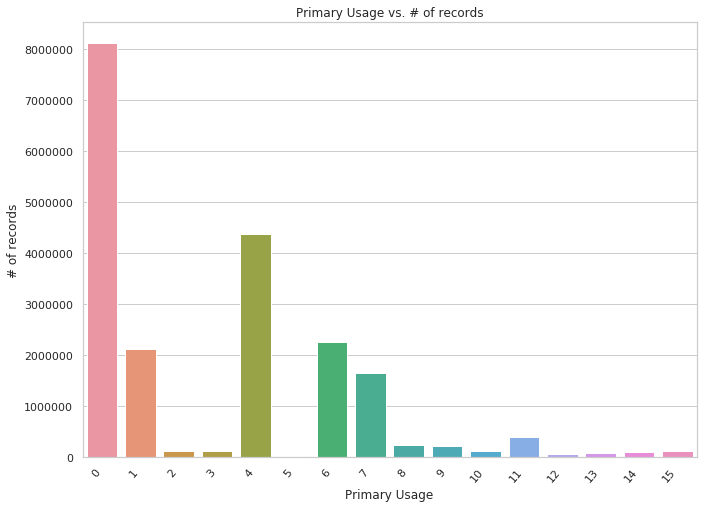

In [33]:
ax = sns.barplot(pd.unique(full_train_df['primary_use']), full_train_df['primary_use'].value_counts())
ax.set(xlabel='Primary Usage', ylabel='# of records', title='Primary Usage vs. # of records')
ax.set_xticklabels(ax.get_xticklabels(), rotation=50, ha="right")
plt.show()

### Distribution of meter types

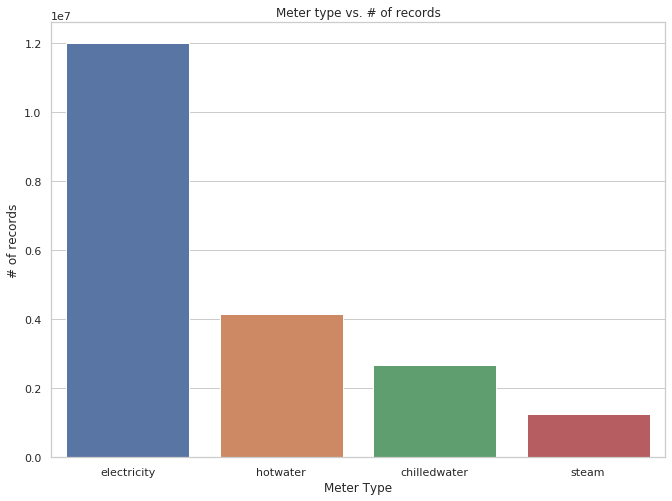

In [34]:
meter_types = {0: 'electricity', 1: 'chilledwater', 2: 'steam', 3: 'hotwater'}
ax = sns.barplot(np.vectorize(meter_types.get)(pd.unique(full_train_df['meter'])), full_train_df['meter'].value_counts())
ax.set(xlabel='Meter Type', ylabel='# of records', title='Meter type vs. # of records')
plt.show()

In [35]:
# Average meter reading
print (f'Average meter reading: {full_train_df.meter_reading.mean()} kWh')

Average meter reading: nan kWh


The average meter reading shows as nan because the individual meter readings (in float16 data type) when added up exceeds the range covered by float16. So we have to allocate float32 or float64 to the feature column so that we can get the mathematical operations done successfully.

In [41]:
full_train_df = full_train_df.astype({"meter_reading":'float32'})

In [42]:
# Average meter reading
print (f'Average meter reading: {full_train_df.meter_reading.mean()} kWh')

Average meter reading: 4.2057414054870605 kWh


### Distribution of meter readings for each meter type

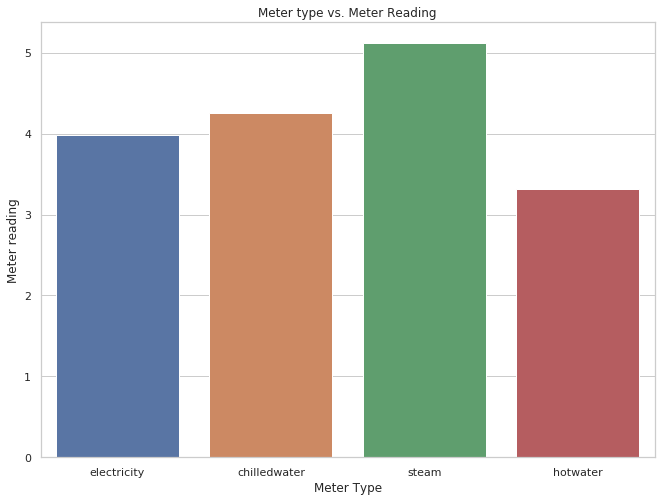

In [43]:
ax = sns.barplot(np.vectorize(meter_types.get)(full_train_df.groupby(['meter'])['meter_reading'].mean().keys()), full_train_df.groupby(['meter'])['meter_reading'].mean())
ax.set(xlabel='Meter Type', ylabel='Meter reading', title='Meter type vs. Meter Reading')
plt.show()

### Distribution of buildings built in each year for both training and test datasets

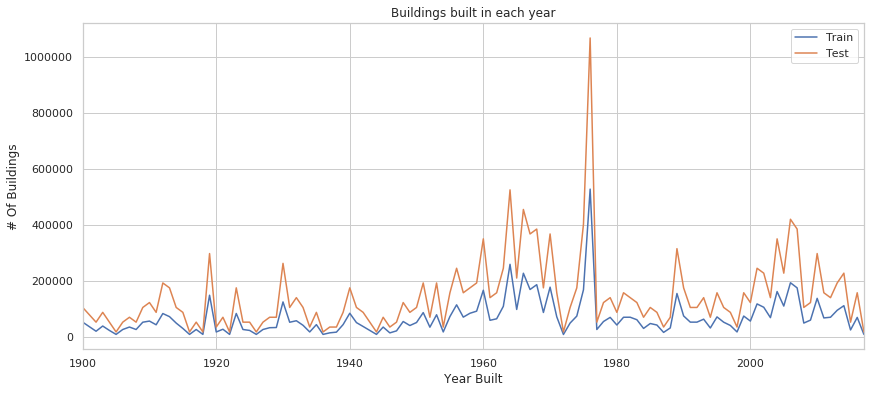

In [44]:
fig, ax = plt.subplots(1,1,figsize=(14, 6))
ax.set(xlabel='Year Built', ylabel='# Of Buildings', title='Buildings built in each year')
full_train_df['year_built'].value_counts(dropna=False).sort_index().plot(ax=ax)
full_test_df['year_built'].value_counts(dropna=False).sort_index().plot(ax=ax)
ax.legend(['Train', 'Test']);

### Distribution of square feet area of buildings

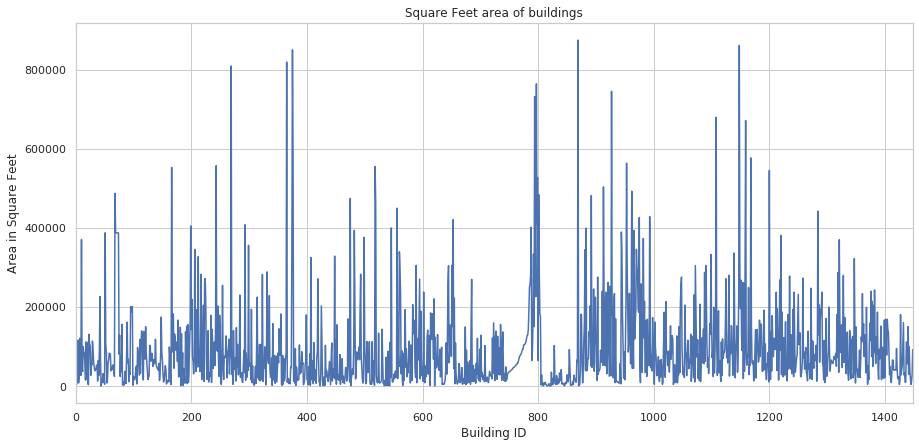

In [46]:
fig, ax = plt.subplots(1,1,figsize=(15, 7))
full_train_df.groupby(['building_id'])['square_feet'].mean().plot(ax=ax)
ax.set(xlabel='Building ID', ylabel='Area in Square Feet', title='Square Feet area of buildings')
plt.show()